# Inspect Playground

In [1]:
from dotenv import load_dotenv
import os

# Load API key from .env file
load_dotenv("../venv/APIs/.env")
api_key = os.getenv("OPENAI_API_KEY")


# FastAI Computer Vision Example

A basic example of training a model to catagorise images into one of 10 categories. CIFAR10 dataset used for training and testing.

In [1]:
from torchvision.datasets import CIFAR10, STL10
from torchvision import transforms
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.CIFAR)   # downloads to ~/.fastai/data/cifar10
path.ls()                       # check what's inside

(#3) [Path('/Users/mattgillie/.fastai/data/cifar10/test'),Path('/Users/mattgillie/.fastai/data/cifar10/labels.txt'),Path('/Users/mattgillie/.fastai/data/cifar10/train')]

In [3]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),       # inputs are images, targets are classes
    get_items=get_image_files,                # how to list image paths
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # 80/20 train/valid split
    get_y=parent_label,                       # derive label from folder name
    item_tfms=Resize(96),                     # resize all images to 96x96
    batch_tfms=Normalize.from_stats(*imagenet_stats)  # normalize pixels
)

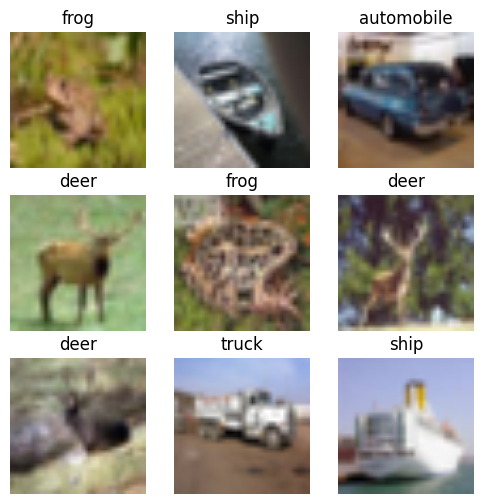

In [4]:
dls = dblock.dataloaders(path, bs=64)
dls.show_batch(max_n=9, figsize=(6,6))

In [ ]:
#Already run - just use weights loaded at bottom
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/mattgillie/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 25.9MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.734599,0.557658,0.187667,02:21


epoch,train_loss,valid_loss,error_rate,time
0,0.365133,0.271003,0.091417,02:12
1,0.192286,0.223003,0.076417,02:08
2,0.047713,0.226381,0.068333,02:10


In [8]:
learn.save('CFIR10_model.pkl')

Path('models/CFIR10_model.pkl.pth')

# Testing the Model

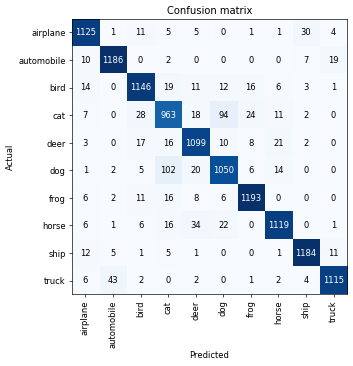

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

<Axes: >

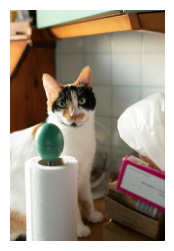

In [21]:
img_path = Path('Data/Images/cat1.jpg')
# 4️⃣ Load and inspect the image
img = PILImage.create(img_path)
img.show(figsize=(3,3))

In [6]:
# Recreate the same architecture
learn = vision_learner(dls, resnet18, metrics=accuracy)

# Then load the weights
learn.load('CFIR10_model.pkl')

pred_class, pred_idx, probs = learn.predict(img)

print(f"🧠 Predicted class: {pred_class}")
print(f"📈 Probability: {probs[pred_idx]:.4f}")

# 6️⃣ Show top predictions (optional)
for c, p in zip(learn.dls.vocab, probs):
    print(f"{c:<15}: {p:.3f}")

🧠 Predicted class: cat
📈 Probability: 0.9528
airplane       : 0.000
automobile     : 0.000
bird           : 0.000
cat            : 0.953
deer           : 0.000
dog            : 0.047
frog           : 0.000
horse          : 0.000
ship           : 0.000
truck          : 0.000


Using target layer: Conv2d
Predicted class: cat


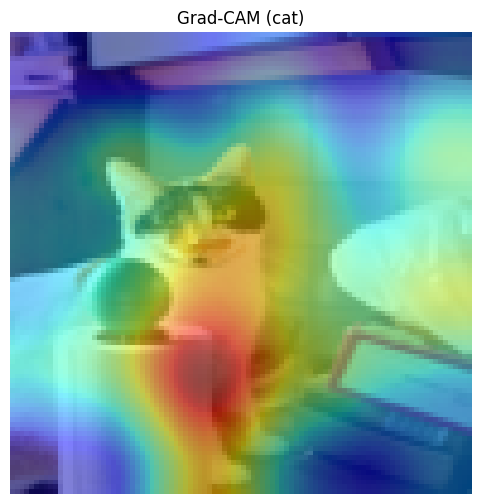

In [20]:
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt, numpy as np
from captum.attr import LayerGradCam
from fastai.vision.all import PILImage

# put model in eval mode
model = learn.model.eval()

# ----- choose a convolutional layer -----
# layer 6 (the second‑to‑last block) has a larger 12×12 feature map
target_layer = learn.model[0][6][-1].conv2
print("Using target layer:", target_layer.__class__.__name__)

# ----- prepare input -----
img_path = 'Data/Images/cat1.jpg'
img = PILImage.create(img_path).resize((96,96))

# apply identical transforms as the learner
img_t = dls.test_dl([img]).one_batch()[0]

# forward pass + predicted class index
pred = model(img_t)
pred_idx = pred.argmax(dim=1).item()
print(f"Predicted class: {learn.dls.vocab[pred_idx]}")

# ----- Grad‑CAM -----
gradcam = LayerGradCam(model, target_layer)
attr = gradcam.attribute(img_t, target=pred_idx)

# resize heatmap to original image size
H, W = np.array(img).shape[:2]
attr_resized = F.interpolate(attr, size=(H, W), mode='bicubic', align_corners=False)

cam = attr_resized[0, 0].detach().cpu().numpy()
cam = (cam - cam.min()) / (cam.max() - cam.min())  # scale to [0, 1]

# ----- visualize -----
plt.figure(figsize=(8, 6))
plt.imshow(np.array(img))
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title(f"Grad‑CAM ({learn.dls.vocab[pred_idx]})")
plt.show()